<a href="https://colab.research.google.com/github/Voland24/AndrewNgMLCourse/blob/main/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

file = 'ex1data.txt'
cols = np.loadtxt(file, delimiter = ',', usecols = (0,1,2), unpack = True)
X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))
m = y.size
X = np.insert(X,0,1, axis = 1)


Lets see the data

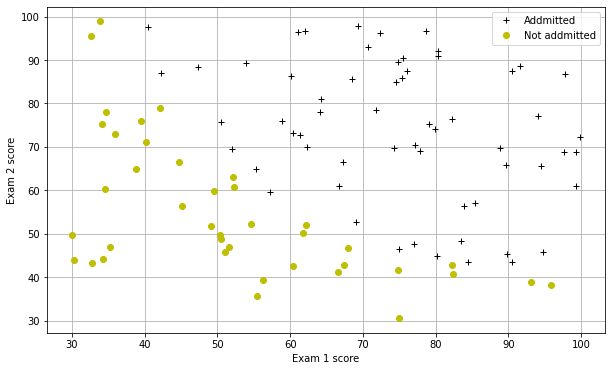

In [2]:
pos_examples = np.array([ X[i] for i in range(X.shape[0]) if y[i] == 1 ])
neg_examples = np.array([ X[i] for i in range(X.shape[0]) if y[i] == 0 ])

def plotExamples():
  plt.figure(figsize = (10,6))
  plt.plot(pos_examples[:,1], pos_examples[:,2], 'k+', label = 'Addmitted')
  plt.plot(neg_examples[:,1], neg_examples[:,2], 'yo', label = 'Not addmitted')
  plt.xlabel("Exam 1 score")
  plt.ylabel("Exam 2 score")
  plt.legend()
  plt.grid(True)

plotExamples()

Form hypothesis and cost function

In [3]:
from scipy.special import expit

def hypothesis(theta_guess, X):
  return expit(np.dot(X, theta_guess))
#lambda is a regularization parameter
def cost_func(theta_guess, X, y, lambda_param = 0):
  term1 = np.dot(-np.array(y).T, np.log(hypothesis(theta_guess, X))) #for y = 1
  term2 = np.dot(1-np.array(y).T, np.log(1 - hypothesis(theta_guess, X))) #for y = 0
  regular_term = (lambda_param / 2) * np.sum(np.dot(theta_guess[1:].T, theta_guess[1:]))
  return float( (1./m) * (np.sum(term1 - term2) + regular_term))

init_theta = np.zeros((X.shape[1], 1))
cost_func(init_theta, X, y)

0.6931471805599453

Instead of plain GD, we will use a special optimizer function that uses downhill simplex algorithm

In [4]:
from scipy import optimize

def optimizeTheta(theta_guess, X , y, lambda_param = 0):
  res = optimize.fmin(cost_func, x0 = theta_guess, args = (X, y, lambda_param), maxiter = 500, full_output=True)
  return res[0], res[1]

theta, min_cost = optimizeTheta(init_theta, X, y)

print(cost_func(theta, X, y))

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287
0.2034977015902151


The theta params are a parametric representation of the decision boundary used for classification, so lets see the boundary now

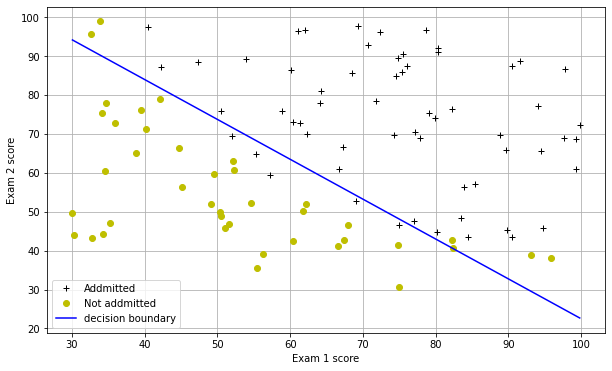

In [5]:
bx = np.array([np.min(X[:,1]), np.max(X[:,1])])
by = (-1 / theta[2]) * (theta[0] + theta[1] * bx)
plotExamples()
plt.plot(bx, by, 'b-', label = 'decision boundary')
plt.legend()

Example of usage, if we have a student with a score of 51 on exam 1 and a score of 80 on exam 2, will he/she be addmitted? 

In [6]:
print(hypothesis(theta, np.array([1,51.,80.])))

0.8136973715938582


In [7]:
def predict(theta, X):
  return hypothesis(theta, X ) >= 0.5

correct_positive = float(np.sum(predict(theta, pos_examples)))
correct_negative = float(np.sum(np.invert(predict(theta, neg_examples))))
total = len(pos_examples) + len(neg_examples)
percent = float(correct_positive + correct_negative) / total
print(f"Correctly predicted {percent} % of examples")

Correctly predicted 0.89 % of examples


Using regularization

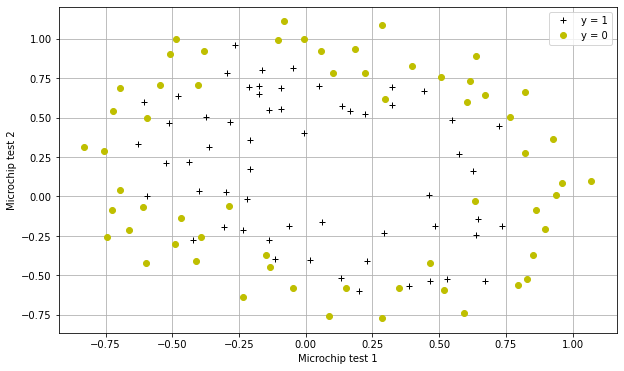

In [8]:
file = 'ex2data.txt'
cols = np.loadtxt(file, delimiter = ',', usecols = (0,1,2), unpack = True)
X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))
m = y.size
X = np.insert(X, 0,1,axis = 1)

pos_examples = np.array([X[i] for i in range(X.shape[0]) if y[i] == 1])
neg_examples = np.array([X[i] for i in range(X.shape[0]) if y[i] == 0])

def plotExamples():
  plt.plot(pos_examples[:,1], pos_examples[:,2], 'k+', label = 'y = 1')
  plt.plot(neg_examples[:,1], neg_examples[:,2], 'yo', label = 'y = 0')
  plt.xlabel('Microchip test 1')
  plt.ylabel('Microchip test 2')
  plt.legend()
  plt.grid(True)

plt.figure(figsize = (10,6))
plotExamples()

We see that the decision boundary must be something diferent than a linear function. some higher order polynomial will do

In order to do that we must map more features in our dataset, in the HW it was given to be 28 features in total
This way we have enough data to fit a higher order polynomial to our dataset, because we will have terms such as x1, x1^2, x1^3 etc

In [9]:
def mapFeature( x1col, x2col ):
    degrees = 6
    out = np.ones( (x1col.shape[0], 1) )

    for i in range(1, degrees+1):
        for j in range(0, i+1):
            term1 = x1col ** (i-j)
            term2 = x2col ** (j)
            term  = (term1 * term2).reshape( term1.shape[0], 1 ) 
            out   = np.hstack(( out, term ))
    return out

mappedX = mapFeature(X[:,1], X[:,2])

mappedX.shape


(118, 28)

In [10]:
init_theta = np.zeros((mappedX.shape[1], 1))
cost_func(init_theta, mappedX,y)

0.6931471805599454

Cost function and optimization

In [11]:
def optimizeThetaRegularized(theta_guess, X, y, lambda_param = 0.):
  res = optimize.minimize(cost_func, theta_guess, args=(X, y, lambda_param),  method='BFGS', options={"maxiter":500, "disp":False} )
  return np.array([res.x]), res.fun

theta, min_cost = optimizeThetaRegularized(init_theta, mappedX, y)


In [12]:
def plotDecisionBound(theta_guess, X, y, lambda_param = 0.):
  theta, min_cost = optimizeThetaRegularized(theta_guess, X, y, lambda_param)
  x_vals = np.linspace(-1,1.5,50)
  y_vals = np.linspace(-1,1.5,50)
  z_vals = np.zeros((len(x_vals), len(y_vals)))
  for i in range(len(x_vals)):
    for j in range(len(y_vals)):
      features_ij = mapFeature(np.array([x_vals[i]]), np.array([y_vals[j]]))
      z_vals[i][j] = np.dot(theta, features_ij.T)
  z_vals = z_vals.transpose()


  u, v = np.meshgrid( x_vals, y_vals)
  mycontour = plt.contour( x_vals, y_vals, z_vals, [0])
  myfmt = { 0:f"{lambda_param}"}
  plt.clabel(mycontour, inline=1, fontsize=15, fmt=myfmt)
  plt.title("Decision Boundary")

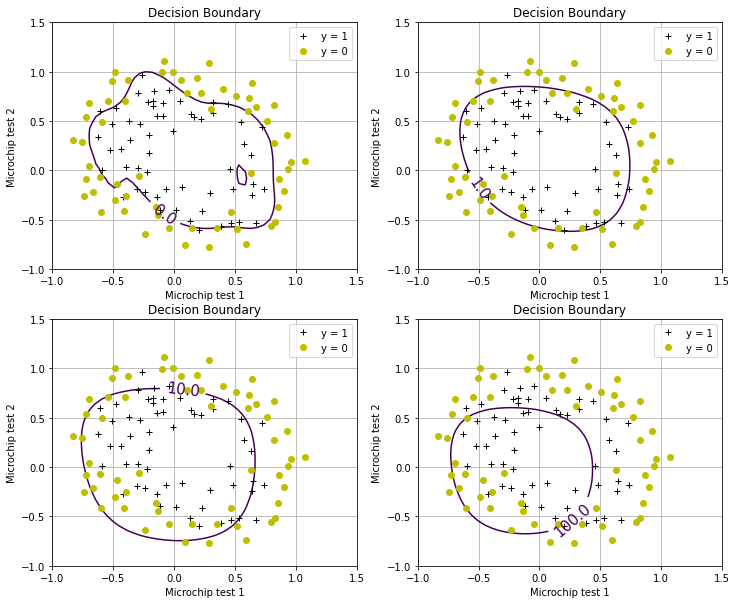

In [13]:
plt.figure(figsize = (12,10))
plt.subplot(221)
plotExamples()
plotDecisionBound(theta, mappedX, y, 0.)

plt.subplot(222)
plotExamples()
plotDecisionBound(theta, mappedX, y, 1.)


plt.subplot(223)
plotExamples()
plotDecisionBound(theta, mappedX, y, 10.)


plt.subplot(224)
plotExamples()
plotDecisionBound(theta, mappedX, y, 100.)

We see that without regularization, the shape is more complex but also highly prone to variance and might not scale well with new data.
Lambda = 1 seems to be the best fit for this example.